In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

In [4]:
from generate_sample import SampleGenerator
import numpy as np

In [156]:
sg = SampleGenerator("poisson", [{'lambda':5}, {'lambda': 20}], 2, 
                     np.array([[0.8, 0.2],[0.1, 0.9]]))

In [157]:
vals, states_orig = sg.generate_samples(300)

In [158]:
states_orig = np.array(states_orig)
vals = np.array(vals)

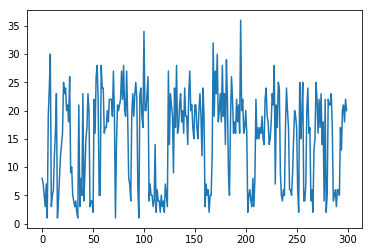

In [159]:
plt.plot(np.arange(len(vals)), vals)

In [160]:
class StateTransitions(pm.Categorical):
    
    def __init__(self, trans_prob=None, init_prob=None, *args, **kwargs):
        
        super(pm.Categorical, self).__init__(*args, **kwargs)
        
        self.trans_prob = trans_prob
        self.init_prob = init_prob
        
        # Housekeeping
        self.mode = tt.cast(0,dtype='int64')
        self.k = 2
        
    def logp(self, x):
        
        trans_prob = self.trans_prob
        
        p = trans_prob[x[:-1]] # probability of the previous state you were in
        x_i = x[1:]            # the state you end up in
        
        log_p = pm.Categorical.dist(p, shape=(self.shape[0],2)).logp_sum(x_i)
        
        return pm.Categorical.dist(self.init_prob).logp(x[0]) + log_p

In [161]:
class PoissionProcess(pm.Discrete):
    
    def __init__(self, state=None, lambdas=None, *args, **kwargs):
        
        super(PoissionProcess, self).__init__(*args, **kwargs)
        
        self.state = state
        self.lambdas = lambdas
    
    def logp(self, x):
        
        lambd = self.lambdas[self.state]
        llike = pm.Poisson.dist(lambd).logp_sum(x)
            
        return llike

In [162]:
vals = np.array(vals)

In [163]:
with pm.Model() as m:
    
    lambd_0 = pm.Gamma('lam0', mu = 10, sd = 100)
    lambd_1 = pm.Gamma('lam1', mu = 50, sd = 100)
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones(2), shape=2)
    state_trans = pm.Dirichlet('state_trans', a = tt.ones(2), shape=(2,2))
    
    pm.Potential('ordering', tt.switch(tt.lt(lambd_1, lambd_0), -np.inf, 0))
    
    lambdas = tt.stack([lambd_0, lambd_1])
    
    states = StateTransitions('states', state_trans, init_probs, shape=len(vals))
    
    y = PoissionProcess('Output', states, lambdas, observed=vals)

In [164]:
with m:
    trace = pm.sample(tune=1000, sample=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [state_trans, init_probs, lam1, lam0]
>BinaryGibbsMetropolis: [states]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:11<00:00, 84.28draws/s]


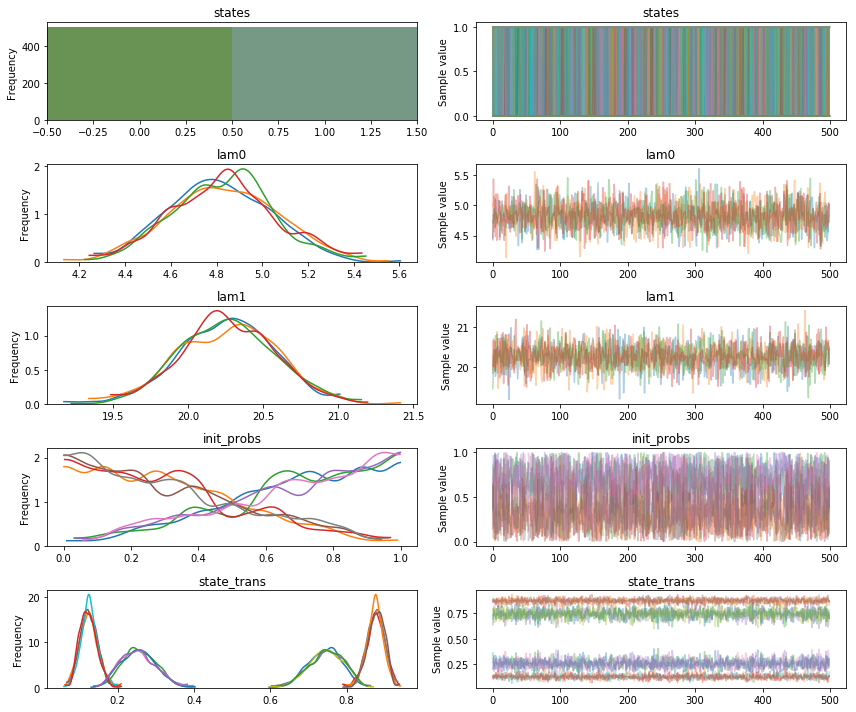

In [165]:
pm.traceplot(trace);

In [172]:
pm.summary(varnames=['init_probs'], trace=trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
init_probs__0,0.671297,0.233625,0.004219,0.225768,0.999216,3286.95352,0.99902
init_probs__1,0.328703,0.233625,0.004219,0.000784,0.774232,3286.95352,0.99902


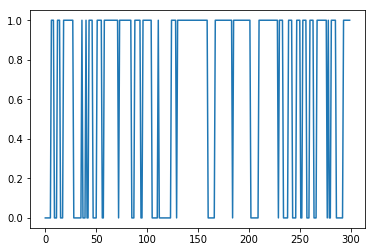

In [170]:
plt.plot(np.arange(len(vals)), states_orig)

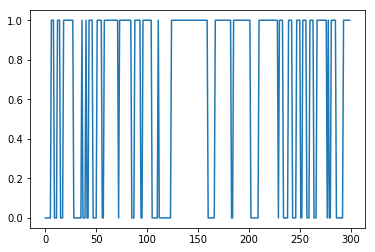

In [171]:
plt.plot(np.arange(len(vals)), np.median(trace['states'], axis=0))